In [2]:
%load_ext pretty_jupyter

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [5]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [7]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [8]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [9]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [10]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [11]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

In [12]:
def cluster_means(adata, clusters):
    obs_clusters = adata.obs.groupby(clusters)
    
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(obs_clusters)), dtype=np.float64),
        columns = list(obs_clusters.groups.keys()),
        index = adata.var.index
    )

    for group, idx in obs_clusters.indices.items():
        X = adata.X[idx]
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [13]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Markers for dotplots

In [14]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'MS4A1', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [15]:
class_markers = [
    'AIM2', # Lower in early memory
    'CD27', # CD27+
    'CD69', # Activated
    'FAS',  # CD95+
    'IGHA1', # Class switching
    'IGHM', # Class switching
    'IGHD', # Class switching
    'IGHG1', # Class switching
    'ITGAX',# CD11c Memory vs Effector
    'MZB1', # Plasmablasts
    'PRDM1',# Plasmablasts
    'TBX21',# Tbet
    'XBP1', # Plasmablasts
    'ZEB2'  #
]

## Read previous, non-tracked labels
We ran a preliminary analysis of our dataset that wasn't tracked for reproducibility. Here, we'll retrieve the labels for visualization and comparison to check for consistency.

In [16]:
original_uuid = '3868592c-0087-4ed8-98b2-4bf1b8676111'
original_df = read_parquet_uuid(original_uuid)
original_df = original_df[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]
original_df = original_df.rename({'AIFI_L1': 'original_L1', 'AIFI_L2': 'original_L2', 'AIFI_L3': 'original_L3'}, axis = 1)

In [17]:
original_df.head()

barcodes original_L1 original_L2 original_L3
0  05ea9806794211eb93b836d1cb6129eb          DC        cDC1        cDC1
1  e225c914794011eb9282e2ceeb91ba52          DC        cDC1        cDC1
2  b1379eae795411eb958b0245821e6993          DC        cDC1        cDC1
3  b13d3a8a795411eb958b0245821e6993          DC        cDC1        cDC1
4  b1430d16795411eb958b0245821e6993          DC        cDC1        cDC1

## Read cell type hierarchy

In [18]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [19]:
search_id = 'nihonium-curium-niobium'

Retrieve files stored in our HISE project store

In [20]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [21]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [22]:
search_df['AIFI_L3'].tolist()

['Activated memory B cell',
 'B reasons',
 'CD27- effector B cell',
 'CD27+ effector B cell',
 'CD95 memory B cell',
 'Core memory B cell',
 'Core naive B cell',
 'Early memory B cell',
 'ISG+ naive B cell',
 'Plasma cell',
 'Transitional B cell',
 'Type 2 polarized memory B cell']

## Review Activated Memory B

In [23]:
cell_type = 'Activated memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [24]:
type_uuid

'1c61fb69-6a5b-49fc-9448-6478d472e2f7'

In [25]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 1c61fb69-6a5b-49fc-9448-6478d472e2f7
Files have been successfully downloaded!


### Clustering

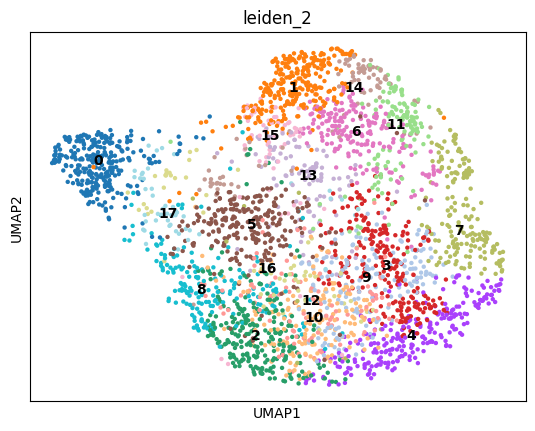

In [26]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

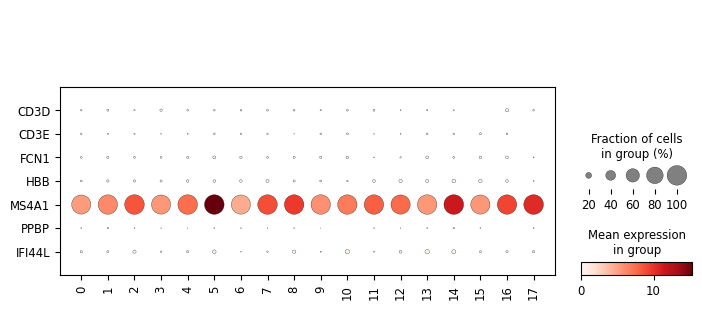

In [27]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

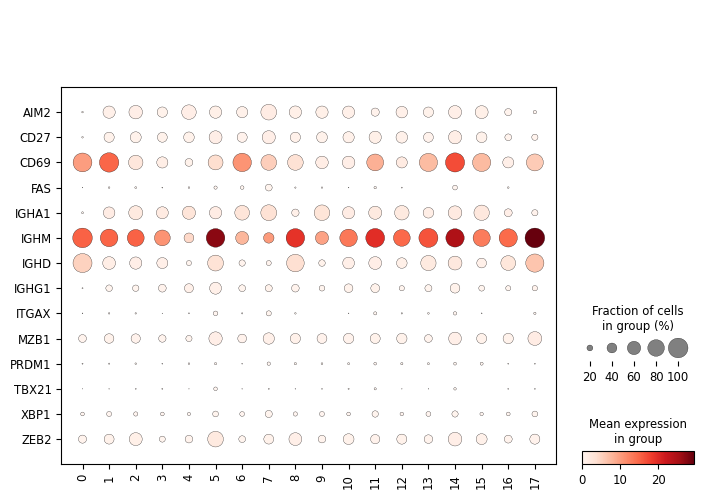

In [28]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [29]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     287
1     276
2     254
3     242
4     242
5     232
6     190
7     185
8     176
9     167
10    164
11    125
12    105
13    102
14     92
15     61
16     54
17     51
Name: count, dtype: int64

### Comparison to original labels

In [30]:
adata = add_labels(adata, original_df)

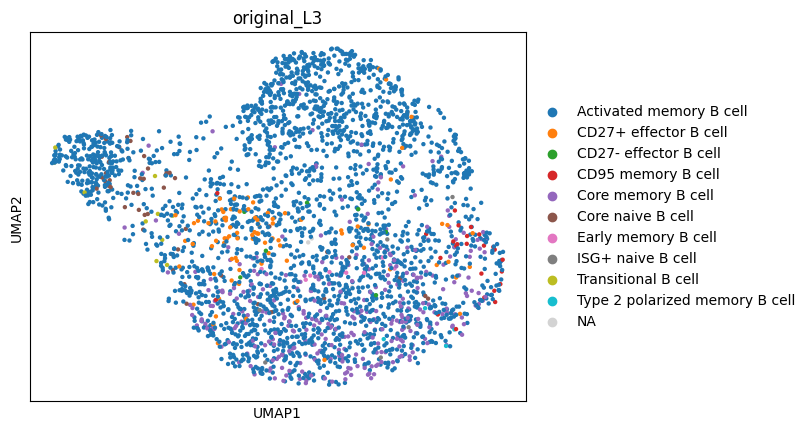

In [31]:
sc.pl.umap(adata, color = 'original_L3')

In [32]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Activated memory B cell           2471
Core memory B cell                 336
CD27+ effector B cell               87
Core naive B cell                   47
CD95 memory B cell                  25
Transitional B cell                 10
Early memory B cell                  8
CD27- effector B cell                7
ISG+ naive B cell                    6
Type 2 polarized memory B cell       4
NaN                                  4
Name: count, dtype: int64

In [33]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Activated memory B cell           0.822296
Core memory B cell                0.111814
CD27+ effector B cell             0.028952
Core naive B cell                 0.015641
CD95 memory B cell                0.008319
Transitional B cell               0.003328
Early memory B cell               0.002662
CD27- effector B cell             0.002329
ISG+ naive B cell                 0.001997
Type 2 polarized memory B cell    0.001331
NaN                               0.001331
Name: count, dtype: float64

## Review CD27- effector B cell

In [34]:
cell_type = 'CD27- effector B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [35]:
type_uuid

'bbf71288-c9e7-4100-bc87-bf8535f0da50'

In [36]:
adata = read_adata_uuid(type_uuid)

downloading fileID: bbf71288-c9e7-4100-bc87-bf8535f0da50
Files have been successfully downloaded!


### Clustering

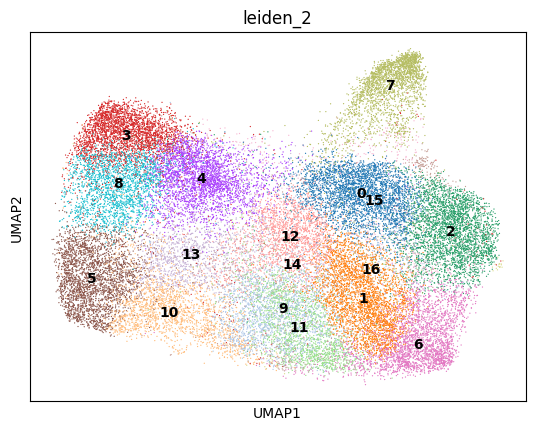

In [37]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

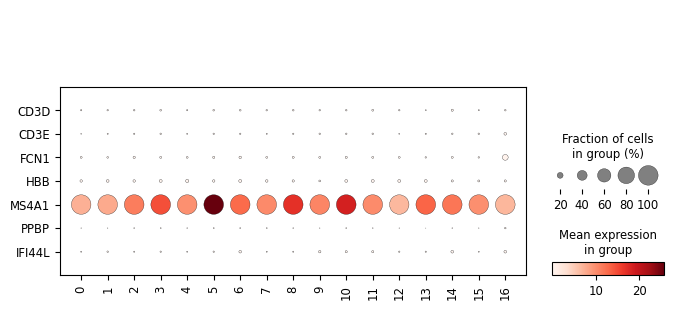

In [38]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

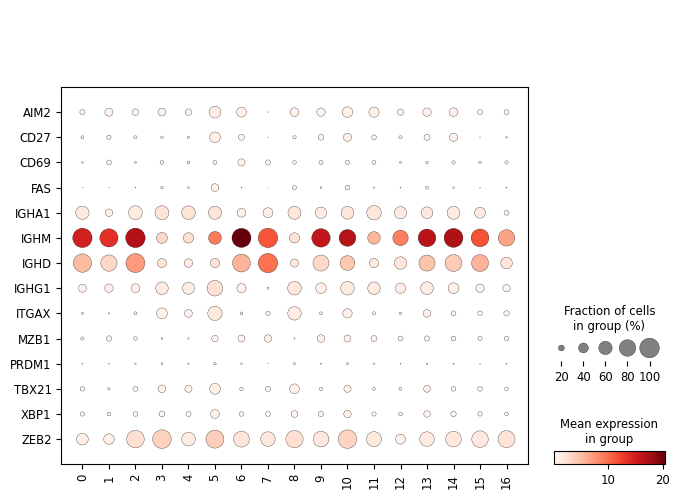

In [39]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [40]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     3231
1     3127
2     3088
3     3032
4     3023
5     2780
6     2775
7     2497
8     2176
9     2148
10    1966
11    1838
12    1702
13    1210
14     717
15     566
16      56
Name: count, dtype: int64

### Comparison to original labels

In [41]:
adata = add_labels(adata, original_df)

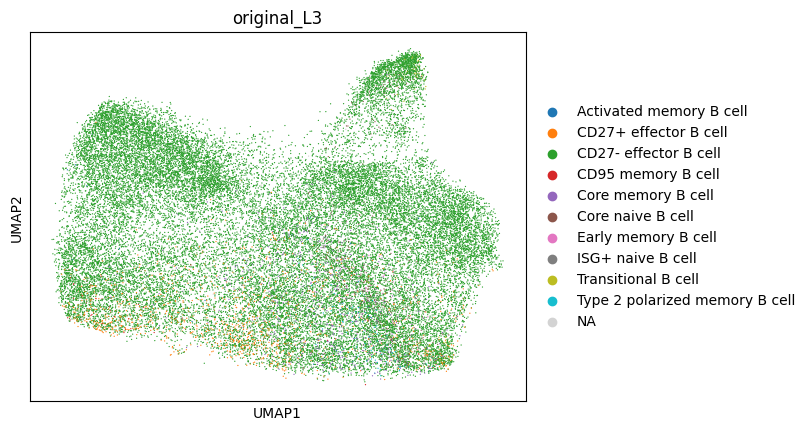

In [42]:
sc.pl.umap(adata, color = 'original_L3')

In [43]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CD27- effector B cell             33165
CD27+ effector B cell              1255
Core memory B cell                  606
Core naive B cell                   430
Type 2 polarized memory B cell      110
Transitional B cell                 104
Early memory B cell                  88
NaN                                  72
CD95 memory B cell                   42
ISG+ naive B cell                    42
Activated memory B cell              18
Name: count, dtype: int64

In [44]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CD27- effector B cell             0.922993
CD27+ effector B cell             0.034927
Core memory B cell                0.016865
Core naive B cell                 0.011967
Type 2 polarized memory B cell    0.003061
Transitional B cell               0.002894
Early memory B cell               0.002449
NaN                               0.002004
CD95 memory B cell                0.001169
ISG+ naive B cell                 0.001169
Activated memory B cell           0.000501
Name: count, dtype: float64

## Review CD27+ effector B cell

In [45]:
cell_type = 'CD27+ effector B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [46]:
type_uuid

'6194891b-b081-42e4-b530-fd08bfbd3344'

In [47]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 6194891b-b081-42e4-b530-fd08bfbd3344
Files have been successfully downloaded!


### Clustering

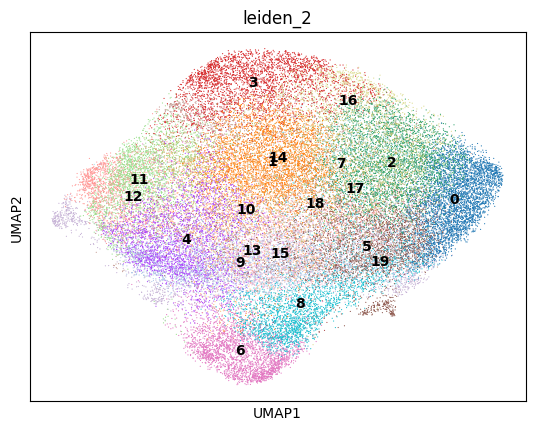

In [48]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

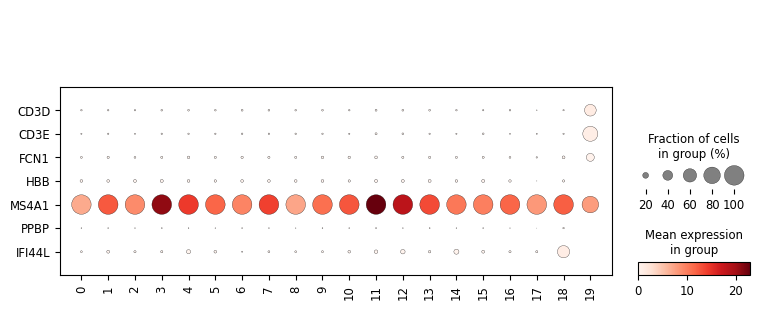

In [49]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

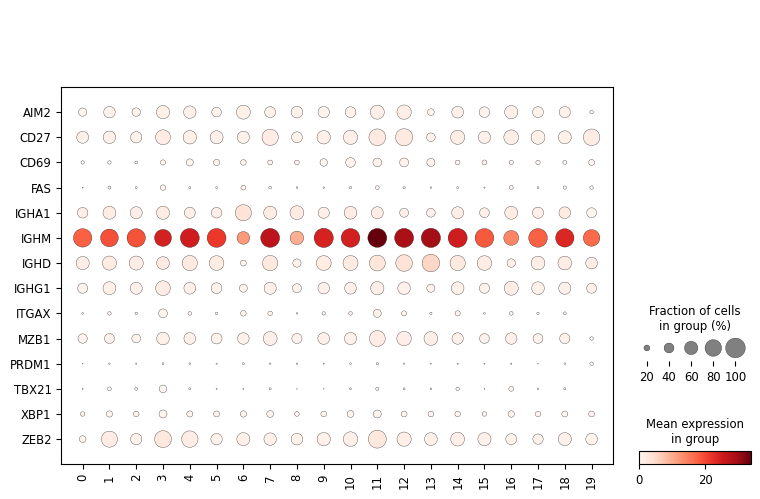

In [50]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [51]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     3849
1     3345
2     3102
3     3073
4     2992
5     2907
6     2844
7     2797
8     2782
9     2731
10    2248
11    2224
12    2134
13    1674
14    1287
15    1275
16    1055
17     818
18     244
19      10
Name: count, dtype: int64

### Comparison to original labels

In [52]:
adata = add_labels(adata, original_df)

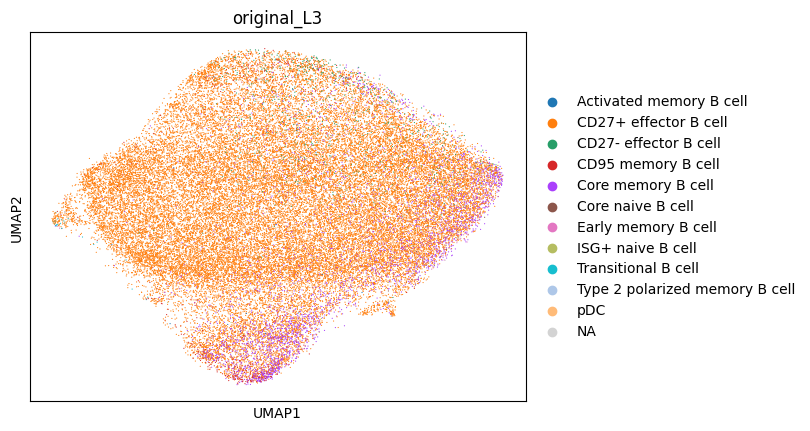

In [53]:
sc.pl.umap(adata, color = 'original_L3')

In [54]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CD27+ effector B cell             38364
Core memory B cell                 3283
CD27- effector B cell               743
CD95 memory B cell                  553
NaN                                 145
Early memory B cell                 126
ISG+ naive B cell                    84
Core naive B cell                    43
Transitional B cell                  23
Activated memory B cell              21
Type 2 polarized memory B cell        5
pDC                                   1
Name: count, dtype: int64

In [55]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CD27+ effector B cell             0.884146
Core memory B cell                0.075661
CD27- effector B cell             0.017123
CD95 memory B cell                0.012745
NaN                               0.003342
Early memory B cell               0.002904
ISG+ naive B cell                 0.001936
Core naive B cell                 0.000991
Transitional B cell               0.000530
Activated memory B cell           0.000484
Type 2 polarized memory B cell    0.000115
pDC                               0.000023
Name: count, dtype: float64

## Review CD95 memory B cell

In [56]:
cell_type = 'CD95 memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [57]:
type_uuid

'690e1fe4-b21b-4492-9689-693726200590'

In [58]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 690e1fe4-b21b-4492-9689-693726200590
Files have been successfully downloaded!


### Clustering

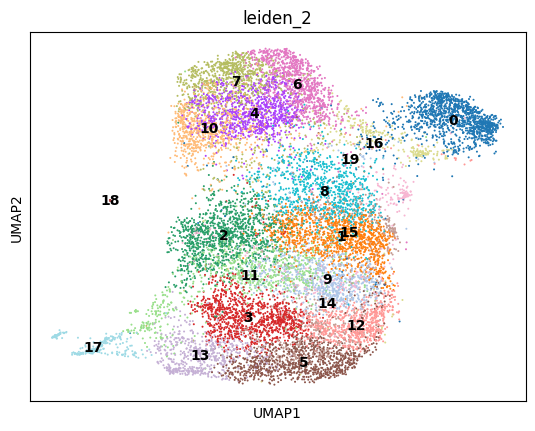

In [59]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

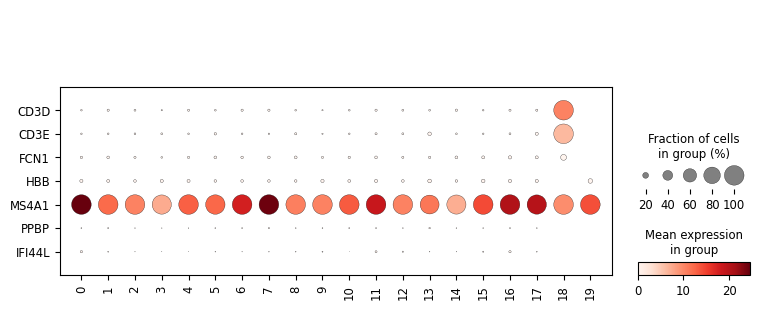

In [60]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

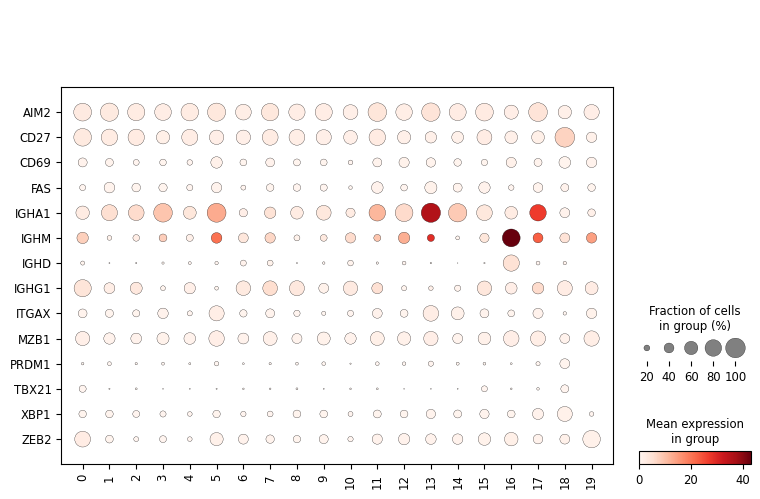

In [61]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [62]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     1261
1     1182
2     1163
3     1052
4      986
5      965
6      925
7      882
8      856
9      804
10     783
11     778
12     680
13     593
14     542
15     332
16     282
17     258
18      10
19       7
Name: count, dtype: int64

### Comparison to original labels

In [63]:
adata = add_labels(adata, original_df)

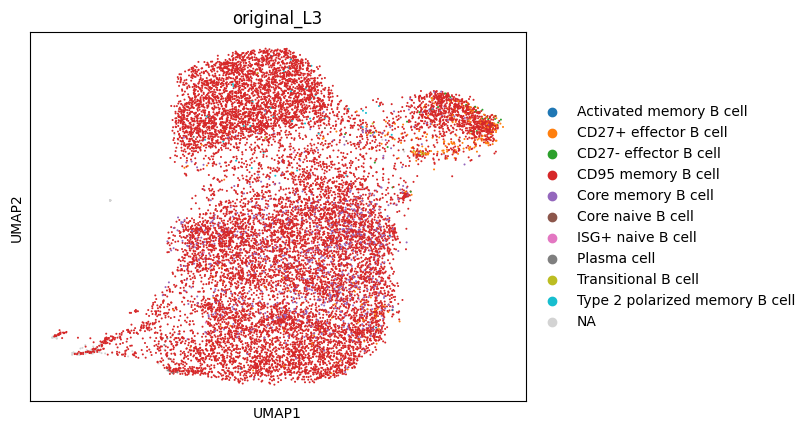

In [64]:
sc.pl.umap(adata, color = 'original_L3')

In [65]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CD95 memory B cell                12958
Core memory B cell                  830
CD27+ effector B cell               308
NaN                                 124
Type 2 polarized memory B cell       41
CD27- effector B cell                28
ISG+ naive B cell                    22
Transitional B cell                  10
Activated memory B cell               8
Plasma cell                           7
Core naive B cell                     5
Name: count, dtype: int64

In [66]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CD95 memory B cell                0.903563
Core memory B cell                0.057876
CD27+ effector B cell             0.021477
NaN                               0.008647
Type 2 polarized memory B cell    0.002859
CD27- effector B cell             0.001952
ISG+ naive B cell                 0.001534
Transitional B cell               0.000697
Activated memory B cell           0.000558
Plasma cell                       0.000488
Core naive B cell                 0.000349
Name: count, dtype: float64

## Review Core memory B cell

In [67]:
cell_type = 'Core memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [68]:
type_uuid

'6b573e6c-c2d4-438d-a948-f02c37c36ecf'

In [69]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 6b573e6c-c2d4-438d-a948-f02c37c36ecf
Files have been successfully downloaded!


### Clustering

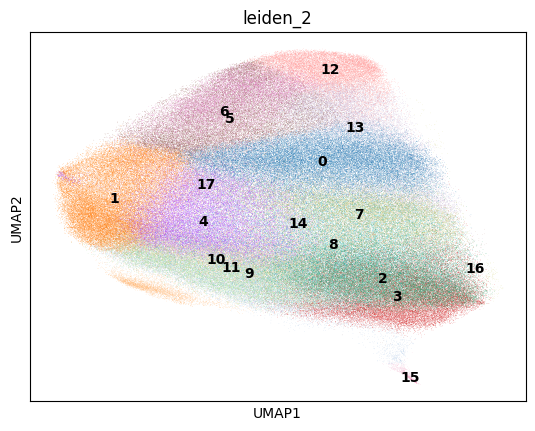

In [70]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

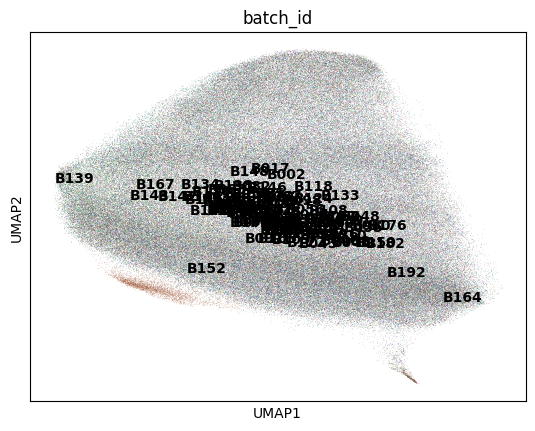

In [71]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

### Marker expression

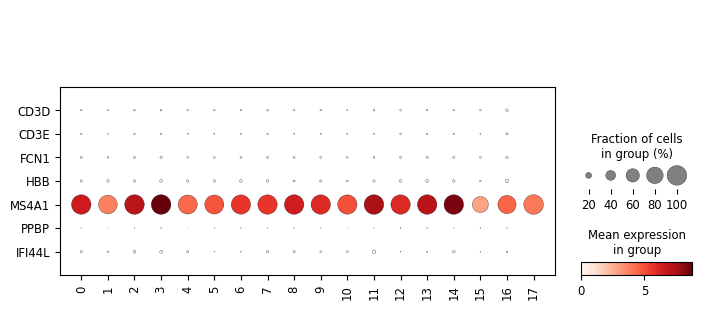

In [72]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

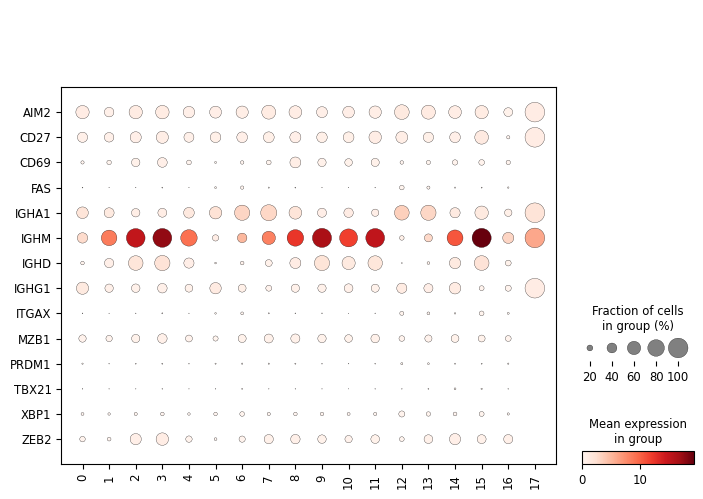

In [73]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [74]:
adata = add_labels(adata, original_df)

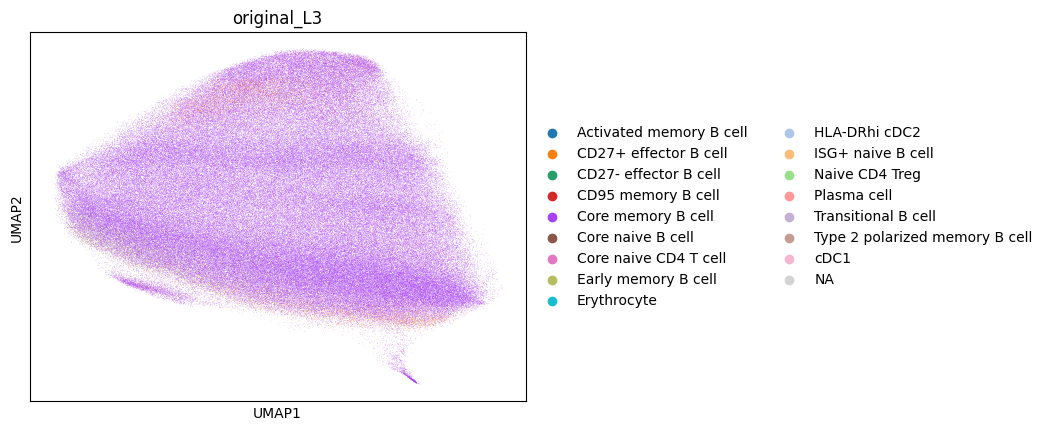

In [75]:
sc.pl.umap(adata, color = 'original_L3')

In [76]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Core memory B cell                285615
CD27+ effector B cell              10651
Early memory B cell                 7735
CD95 memory B cell                  3429
Type 2 polarized memory B cell      2861
NaN                                 1901
Core naive B cell                   1718
ISG+ naive B cell                    832
CD27- effector B cell                779
Activated memory B cell              341
Transitional B cell                   18
Plasma cell                            3
Erythrocyte                            3
Core naive CD4 T cell                  2
HLA-DRhi cDC2                          1
Naive CD4 Treg                         1
cDC1                                   1
Name: count, dtype: int64

In [77]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Core memory B cell                0.904157
CD27+ effector B cell             0.033717
Early memory B cell               0.024486
CD95 memory B cell                0.010855
Type 2 polarized memory B cell    0.009057
NaN                               0.006018
Core naive B cell                 0.005439
ISG+ naive B cell                 0.002634
CD27- effector B cell             0.002466
Activated memory B cell           0.001079
Transitional B cell               0.000057
Plasma cell                       0.000009
Erythrocyte                       0.000009
Core naive CD4 T cell             0.000006
HLA-DRhi cDC2                     0.000003
Naive CD4 Treg                    0.000003
cDC1                              0.000003
Name: count, dtype: float64

## Review Core naive B cell

In [78]:
cell_type = 'Core naive B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [79]:
type_uuid

'4ae8b6d9-598b-4475-baf8-a9e121fc8a89'

In [80]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 4ae8b6d9-598b-4475-baf8-a9e121fc8a89
Files have been successfully downloaded!


### Clustering

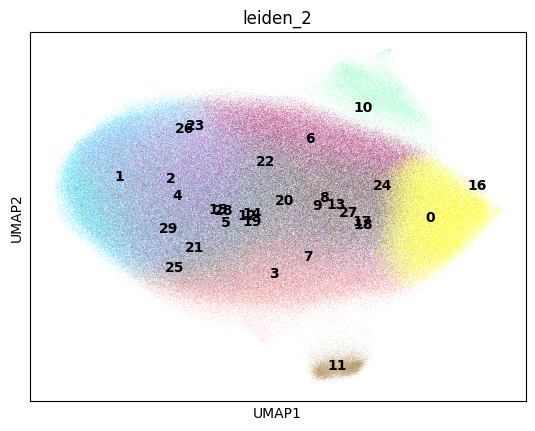

In [81]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

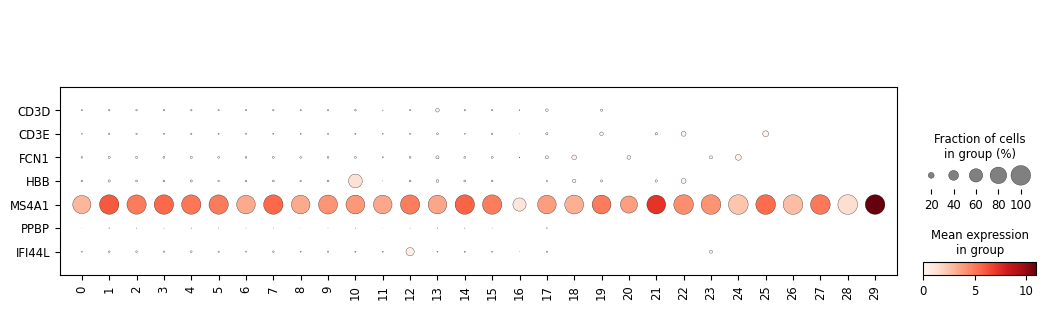

In [82]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

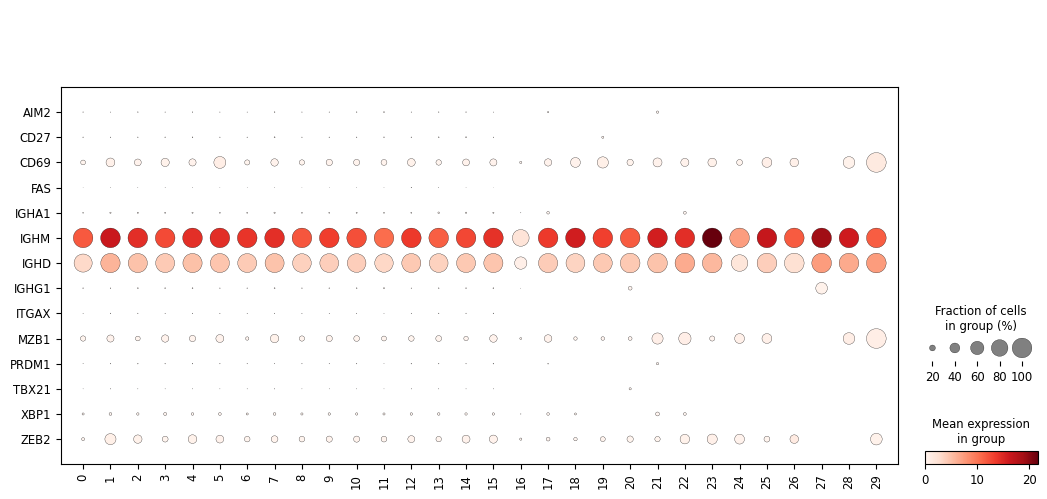

In [83]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

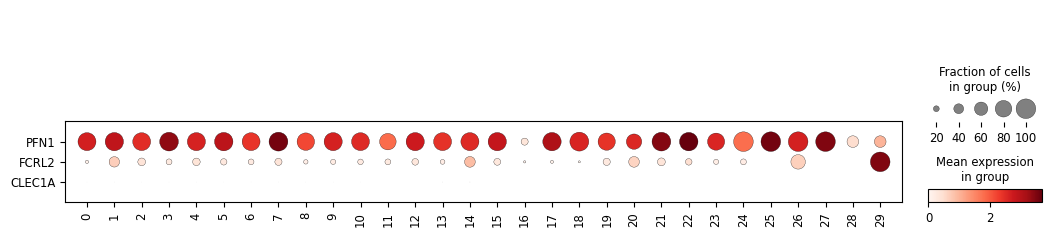

In [84]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['PFN1','FCRL2','CLEC1A'], swap_axes = True)

### Comparison to original labels

In [85]:
adata = add_labels(adata, original_df)

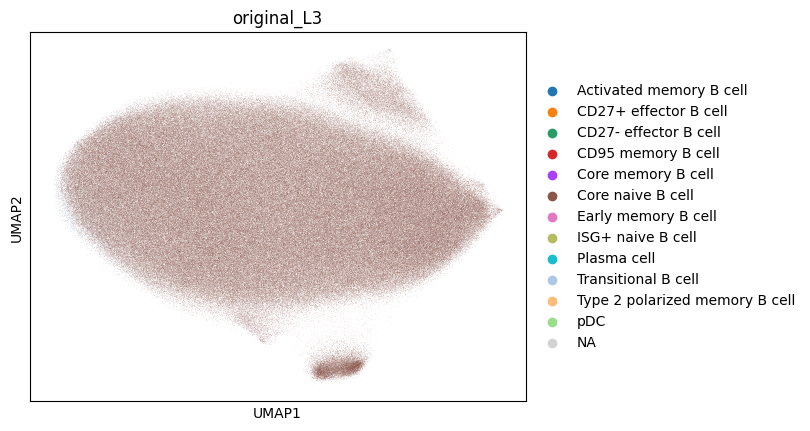

In [86]:
sc.pl.umap(adata, color = 'original_L3')

In [87]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Core naive B cell                 606861
Transitional B cell                10270
NaN                                 7886
ISG+ naive B cell                   1912
Early memory B cell                  964
Core memory B cell                   775
CD27- effector B cell                316
Type 2 polarized memory B cell       272
CD27+ effector B cell                 82
Activated memory B cell               44
CD95 memory B cell                    15
Plasma cell                            1
pDC                                    1
Name: count, dtype: int64

In [88]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Core naive B cell                 0.964191
Transitional B cell               0.016317
NaN                               0.012529
ISG+ naive B cell                 0.003038
Early memory B cell               0.001532
Core memory B cell                0.001231
CD27- effector B cell             0.000502
Type 2 polarized memory B cell    0.000432
CD27+ effector B cell             0.000130
Activated memory B cell           0.000070
CD95 memory B cell                0.000024
Plasma cell                       0.000002
pDC                               0.000002
Name: count, dtype: float64

## Review Early memory B cell

In [89]:
cell_type = 'Early memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [90]:
type_uuid

'49b5f228-4a89-4f06-b170-37095b105f71'

In [91]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 49b5f228-4a89-4f06-b170-37095b105f71
Files have been successfully downloaded!


### Clustering

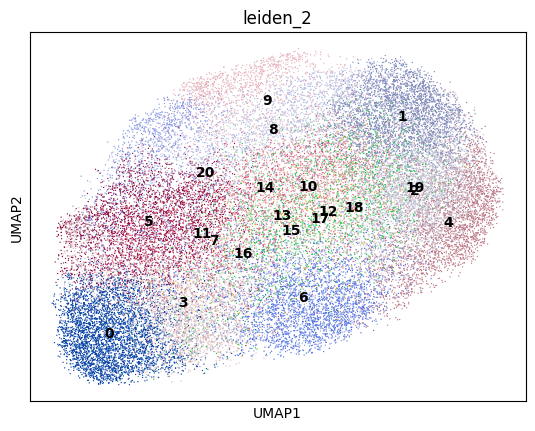

In [92]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

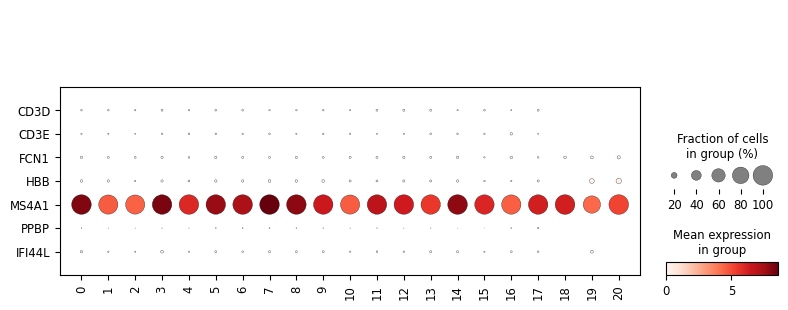

In [93]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

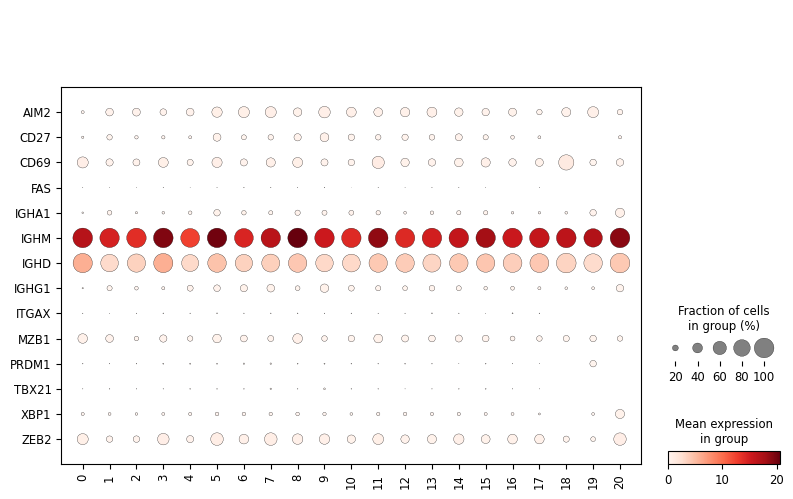

In [94]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [95]:
adata = add_labels(adata, original_df)

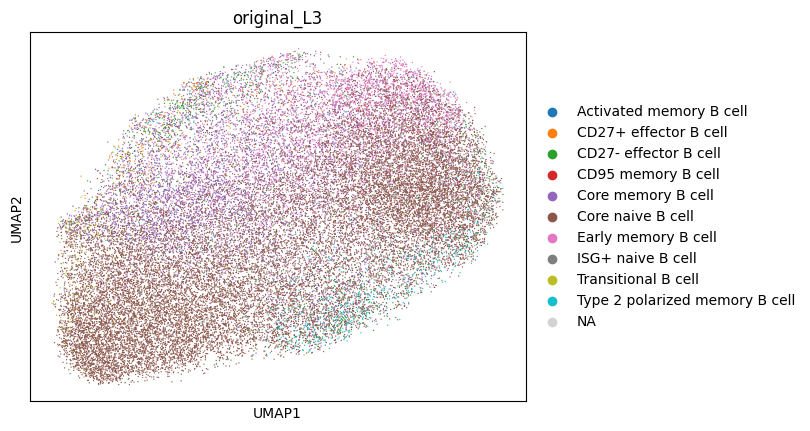

In [96]:
sc.pl.umap(adata, color = 'original_L3')

In [97]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Core naive B cell                 21640
Core memory B cell                 5999
Early memory B cell                3944
CD27- effector B cell               849
Type 2 polarized memory B cell      799
CD27+ effector B cell               294
NaN                                 258
ISG+ naive B cell                   246
Transitional B cell                 237
Activated memory B cell              20
CD95 memory B cell                   13
Name: count, dtype: int64

In [98]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Core naive B cell                 0.630922
Core memory B cell                0.174903
Early memory B cell               0.114989
CD27- effector B cell             0.024753
Type 2 polarized memory B cell    0.023295
CD27+ effector B cell             0.008572
NaN                               0.007522
ISG+ naive B cell                 0.007172
Transitional B cell               0.006910
Activated memory B cell           0.000583
CD95 memory B cell                0.000379
Name: count, dtype: float64

## Review ISG+ naive B cell

In [99]:
cell_type = 'ISG+ naive B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [100]:
type_uuid

'ed548bde-b123-4cad-bd19-6581772eec1f'

In [101]:
adata = read_adata_uuid(type_uuid)

downloading fileID: ed548bde-b123-4cad-bd19-6581772eec1f
Files have been successfully downloaded!


### Clustering

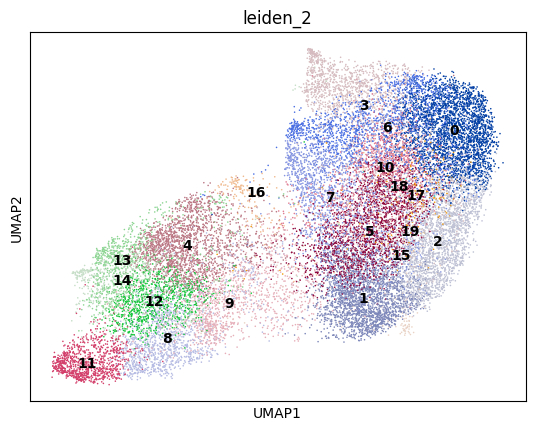

In [102]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

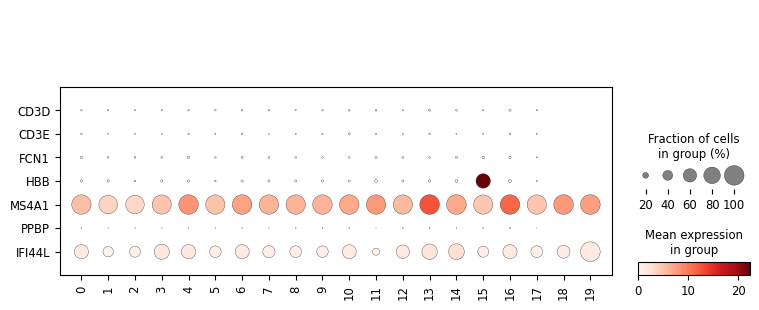

In [103]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

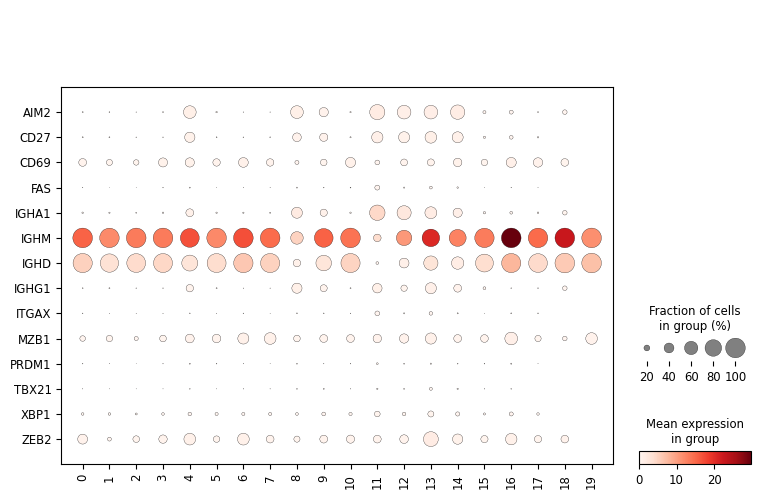

In [104]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [105]:
adata = add_labels(adata, original_df)

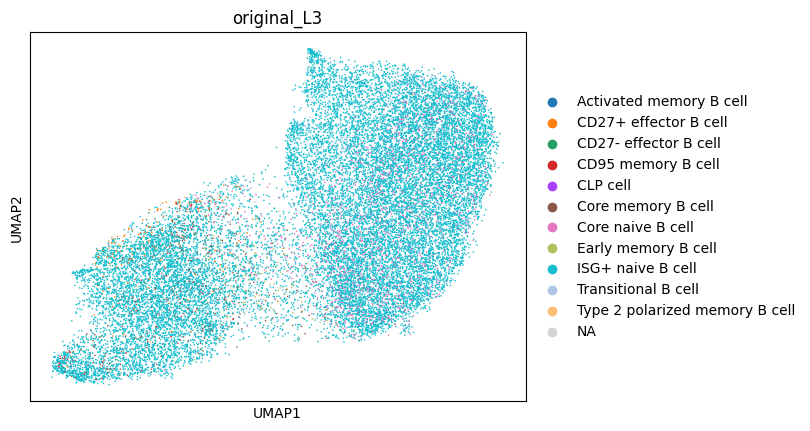

In [106]:
sc.pl.umap(adata, color = 'original_L3')

In [107]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
ISG+ naive B cell                 20536
Core naive B cell                  1517
Core memory B cell                  463
Transitional B cell                 210
CD27+ effector B cell               147
Early memory B cell                 114
NaN                                 110
CD27- effector B cell                50
CD95 memory B cell                   50
Type 2 polarized memory B cell       28
Activated memory B cell               4
CLP cell                              2
Name: count, dtype: int64

In [108]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
ISG+ naive B cell                 0.883991
Core naive B cell                 0.065301
Core memory B cell                0.019930
Transitional B cell               0.009040
CD27+ effector B cell             0.006328
Early memory B cell               0.004907
NaN                               0.004735
CD27- effector B cell             0.002152
CD95 memory B cell                0.002152
Type 2 polarized memory B cell    0.001205
Activated memory B cell           0.000172
CLP cell                          0.000086
Name: count, dtype: float64

## Review Plasma cell

In [109]:
cell_type = 'Plasma cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [110]:
type_uuid

'cf39f473-5a33-4d51-a5fa-c5332981d2f4'

In [111]:
adata = read_adata_uuid(type_uuid)

downloading fileID: cf39f473-5a33-4d51-a5fa-c5332981d2f4
Files have been successfully downloaded!


### Clustering

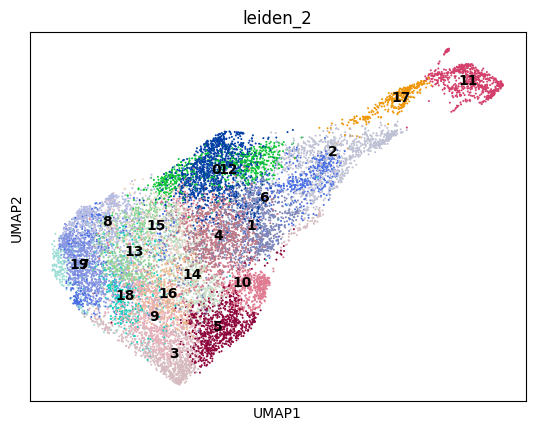

In [112]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

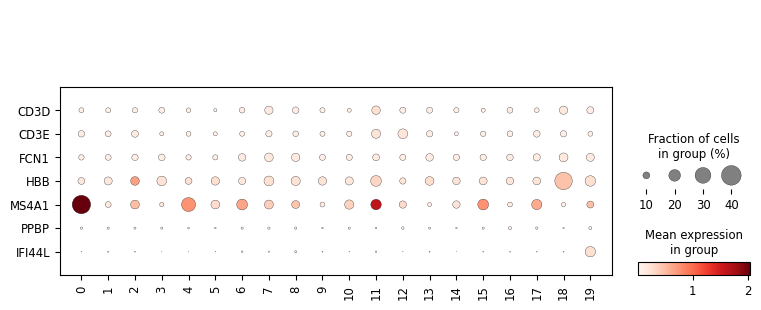

In [113]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

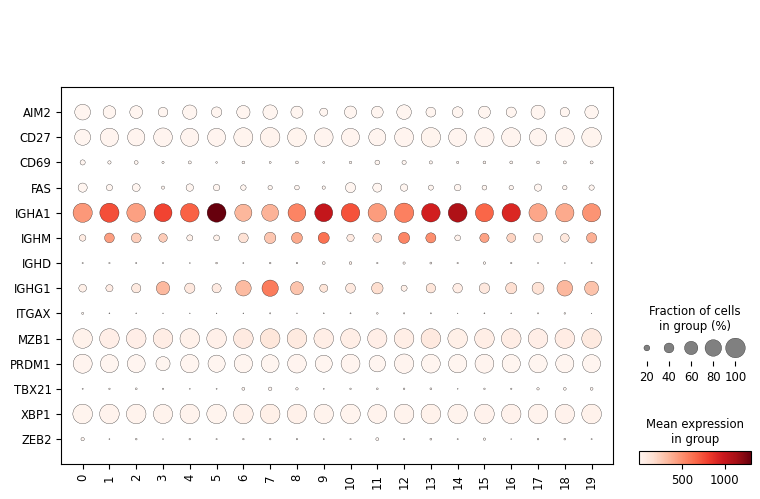

In [114]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [115]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     1220
1      985
2      933
3      931
4      920
5      854
6      818
7      811
8      777
9      774
10     735
11     688
12     658
13     561
14     557
15     450
16     433
17     369
18     361
19     326
Name: count, dtype: int64

### Comparison to original labels

In [116]:
adata = add_labels(adata, original_df)

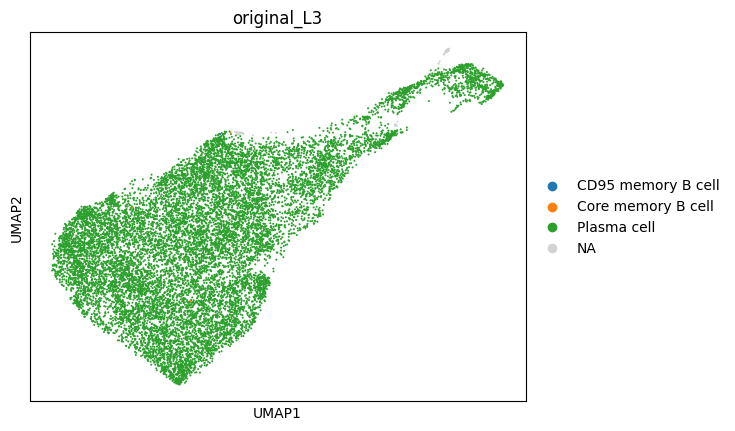

In [117]:
sc.pl.umap(adata, color = 'original_L3')

In [118]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Plasma cell           14057
NaN                     100
Core memory B cell        3
CD95 memory B cell        1
Name: count, dtype: int64

In [119]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Plasma cell           0.992656
NaN                   0.007062
Core memory B cell    0.000212
CD95 memory B cell    0.000071
Name: count, dtype: float64

## Review Transitional B cell

In [120]:
cell_type = 'Transitional B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [121]:
type_uuid

'c23f3fba-3800-4762-a146-929ebb8ef78f'

In [122]:
adata = read_adata_uuid(type_uuid)

downloading fileID: c23f3fba-3800-4762-a146-929ebb8ef78f
Files have been successfully downloaded!


### Clustering

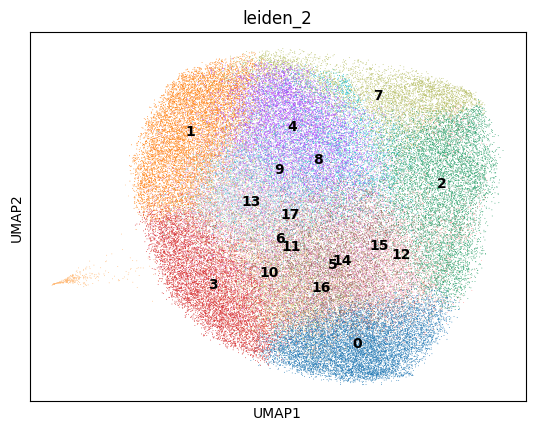

In [123]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

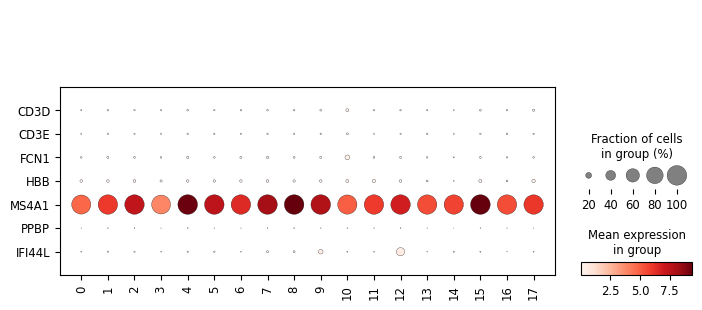

In [124]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

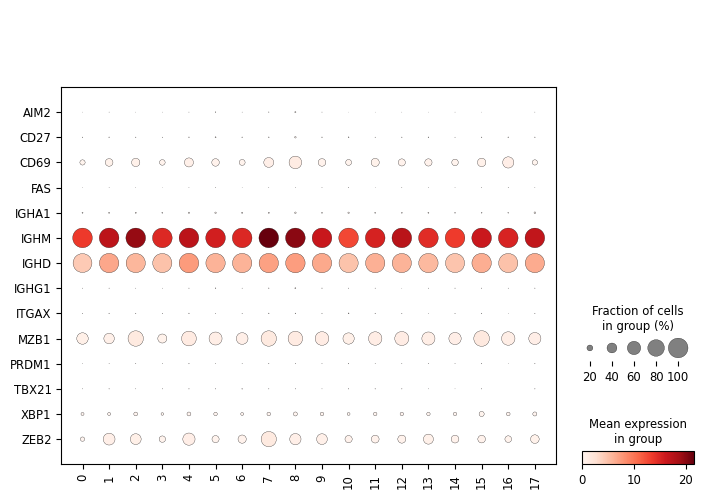

In [125]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [126]:
adata = add_labels(adata, original_df)

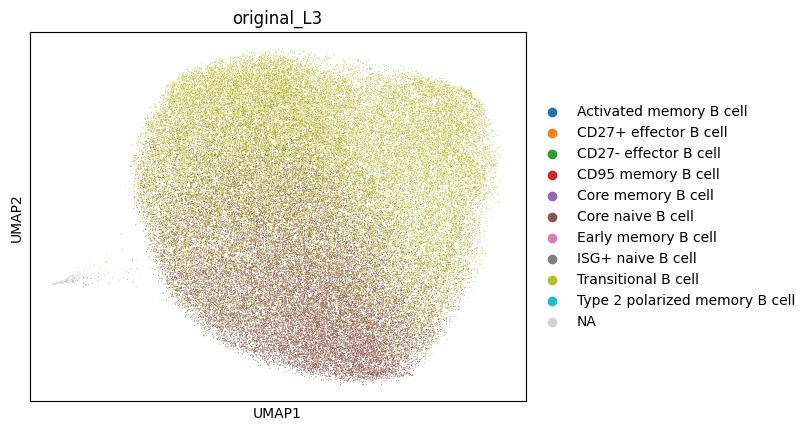

In [127]:
sc.pl.umap(adata, color = 'original_L3')

In [128]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Transitional B cell               46369
Core naive B cell                 33220
NaN                                 964
ISG+ naive B cell                   504
CD27+ effector B cell               128
CD27- effector B cell               106
Early memory B cell                  42
Core memory B cell                   41
CD95 memory B cell                   16
Activated memory B cell              10
Type 2 polarized memory B cell       10
Name: count, dtype: int64

In [129]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Transitional B cell               0.569574
Core naive B cell                 0.408058
NaN                               0.011841
ISG+ naive B cell                 0.006191
CD27+ effector B cell             0.001572
CD27- effector B cell             0.001302
Early memory B cell               0.000516
Core memory B cell                0.000504
CD95 memory B cell                0.000197
Activated memory B cell           0.000123
Type 2 polarized memory B cell    0.000123
Name: count, dtype: float64

## Review Type 2 polarized memory B cell

In [130]:
cell_type = 'Type 2 polarized memory B cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [131]:
type_uuid

'a072ca76-4f05-49df-b213-5441c88cf1b2'

In [132]:
adata = read_adata_uuid(type_uuid)

downloading fileID: a072ca76-4f05-49df-b213-5441c88cf1b2
Files have been successfully downloaded!


### Clustering

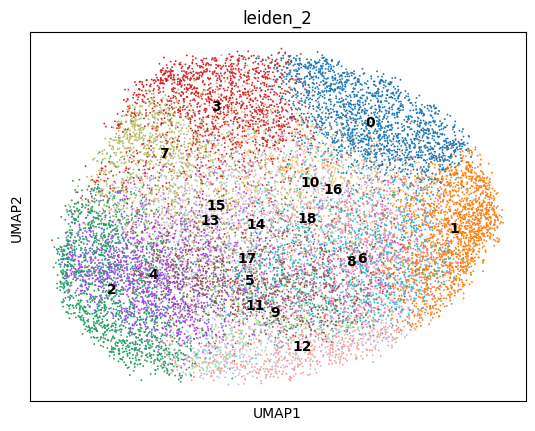

In [133]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

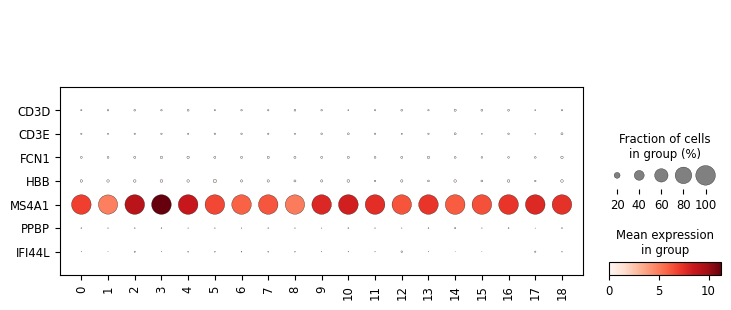

In [134]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

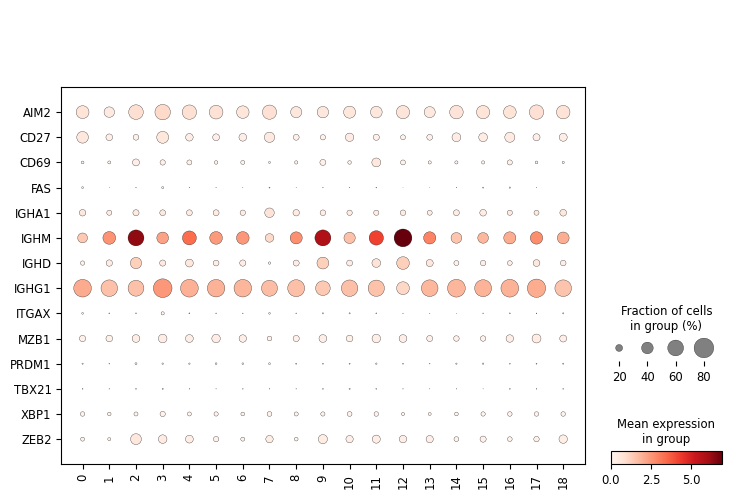

In [135]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [136]:
adata = add_labels(adata, original_df)

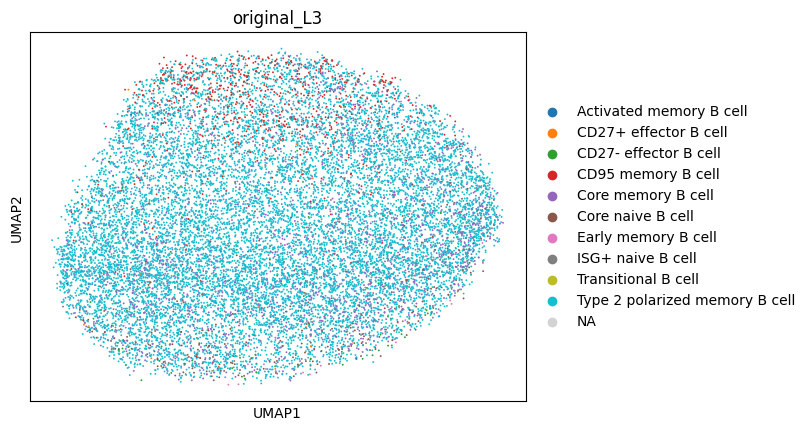

In [137]:
sc.pl.umap(adata, color = 'original_L3')

In [138]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Type 2 polarized memory B cell    13365
Core memory B cell                 2003
CD95 memory B cell                  759
Core naive B cell                   351
CD27- effector B cell                78
ISG+ naive B cell                    47
Early memory B cell                  37
NaN                                  34
CD27+ effector B cell                23
Activated memory B cell              14
Transitional B cell                   1
Name: count, dtype: int64

In [139]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Type 2 polarized memory B cell    0.799725
Core memory B cell                0.119854
CD95 memory B cell                0.045416
Core naive B cell                 0.021003
CD27- effector B cell             0.004667
ISG+ naive B cell                 0.002812
Early memory B cell               0.002214
NaN                               0.002034
CD27+ effector B cell             0.001376
Activated memory B cell           0.000838
Transitional B cell               0.000060
Name: count, dtype: float64

In [1]:
os.system('jupyter nbconvert --to html --template pj 13a-Python_review_filtered_L3_b_cell_data.ipynb')

NameError: name 'os' is not defined

In [141]:
import session_info
session_info.show()